# Mean-Field Optimal Execution - MF Actor-Critic method

> Tip: The notebook assumes `mf_optimal_execution` package is installed (editable mode is fine):  
> `pip install -e ..` and restart the kernel.

In [1]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from mf_optimal_execution.models import PriceImpactModel
from mf_optimal_execution.solutions import OptimalExecutionSolutionPDE_MFG
from mf_optimal_execution.networks import Actor, Critic, Score
from mf_optimal_execution.utils import setup_plt
from mf_optimal_execution.config import Config

In [2]:
CHECKPOINTS_PATH = Path("../checkpoints")

checkpoint_path = None
if checkpoint_path is None:
    candidates = sorted((p for p in CHECKPOINTS_PATH.glob("drl_mfg_*.pt")), key=lambda p: p.stat().st_mtime, reverse=True)
    checkpoint_path = candidates[0]

print(f"Will load: '{checkpoint_path.name}'")

Will load: 'drl_mfg_1760128678.pt'


## Load checkpoint

In [3]:
setup_plt()

ckpt = torch.load(checkpoint_path)

cfg = Config(**ckpt["config"])


dyn = PriceImpactModel(cfg.sigma, cfg.gamma, cfg.ca, cfg.cx, cfg.cg)
sol = OptimalExecutionSolutionPDE_MFG(dyn, cfg)

# Recreate and load model
actor = Actor()
critic = Critic()
score = Score()
actor.load_state_dict(ckpt["actor"], strict=True)
critic.load_state_dict(ckpt["critic"], strict=True)
score.load_state_dict(ckpt["score"], strict=True)

# Training curve
losses = ckpt.get("losses", None)
mean_errors = ckpt.get("mean_errors", None)
std_errors = ckpt.get("std_errors", None)

## Plot results

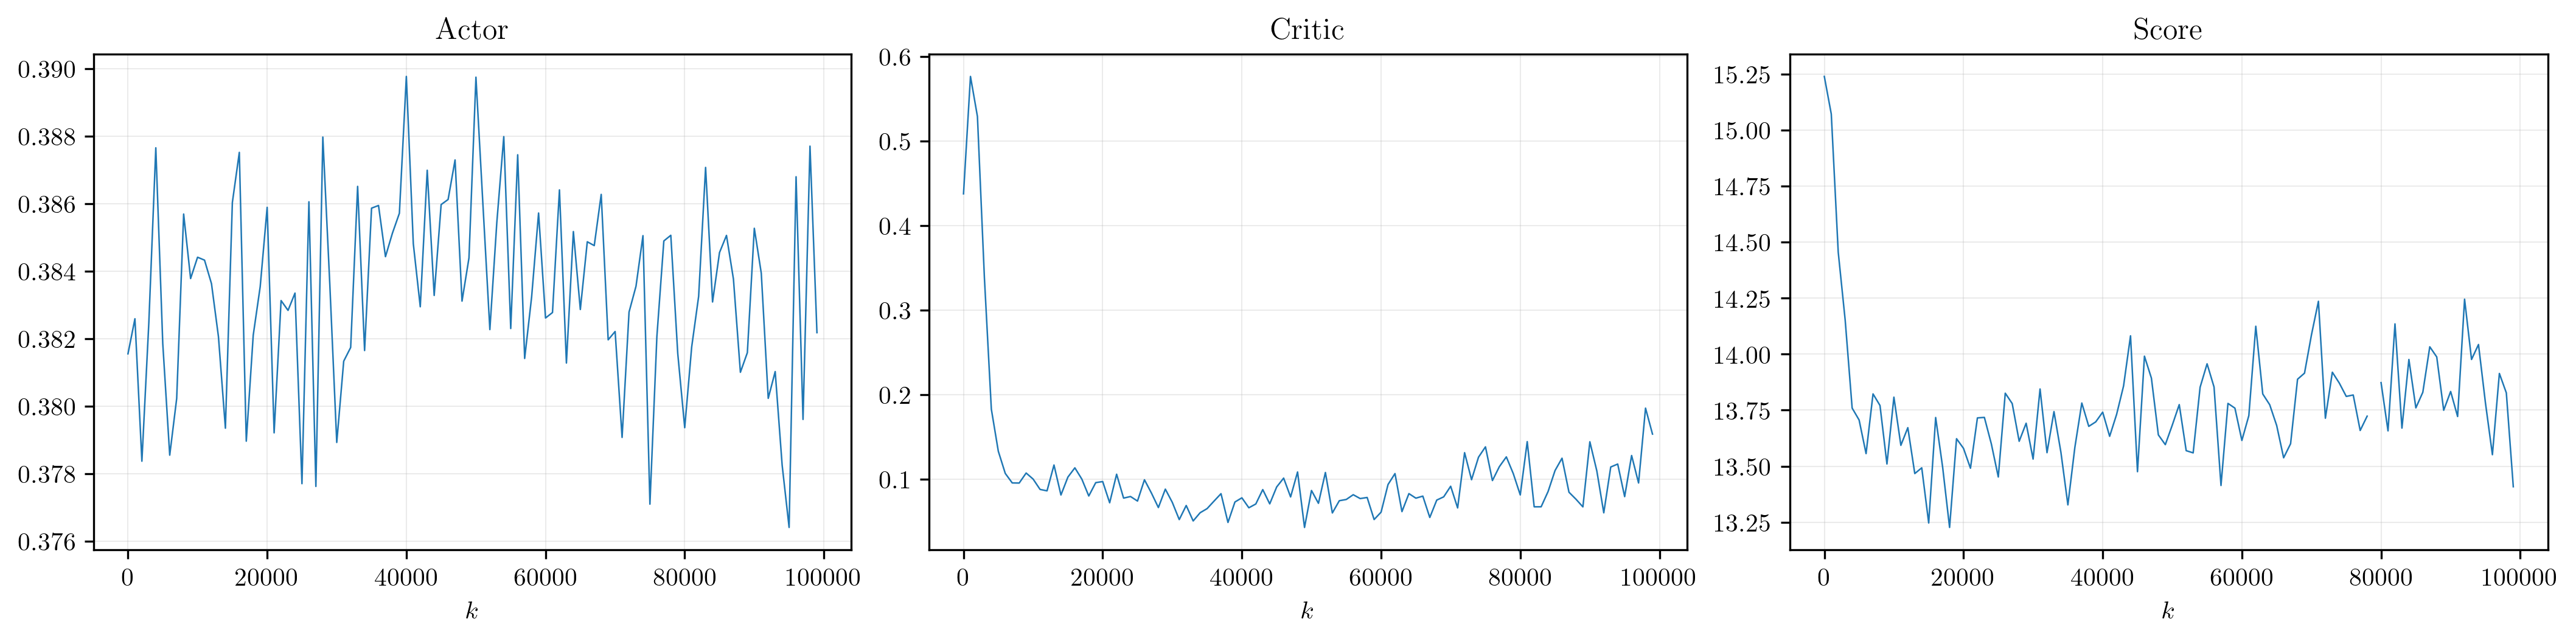

In [4]:
x_epoch = np.arange(losses.size(0)) * 1000

labels = ["Actor", "Critic", "Score"]

fig, axs = plt.subplots(1, 3, figsize=(14, 3.4), dpi=300, sharex=True, constrained_layout=True)

for i in range(3):
    axs[i].plot(x_epoch, mean_errors[:, i], lw=0.6)
    axs[i].set_xlabel("$k$")
    # axs[i].set_yscale("log")
    axs[i].grid(lw=0.5, alpha=0.25)
    axs[i].set_title(labels[i])

plt.show()

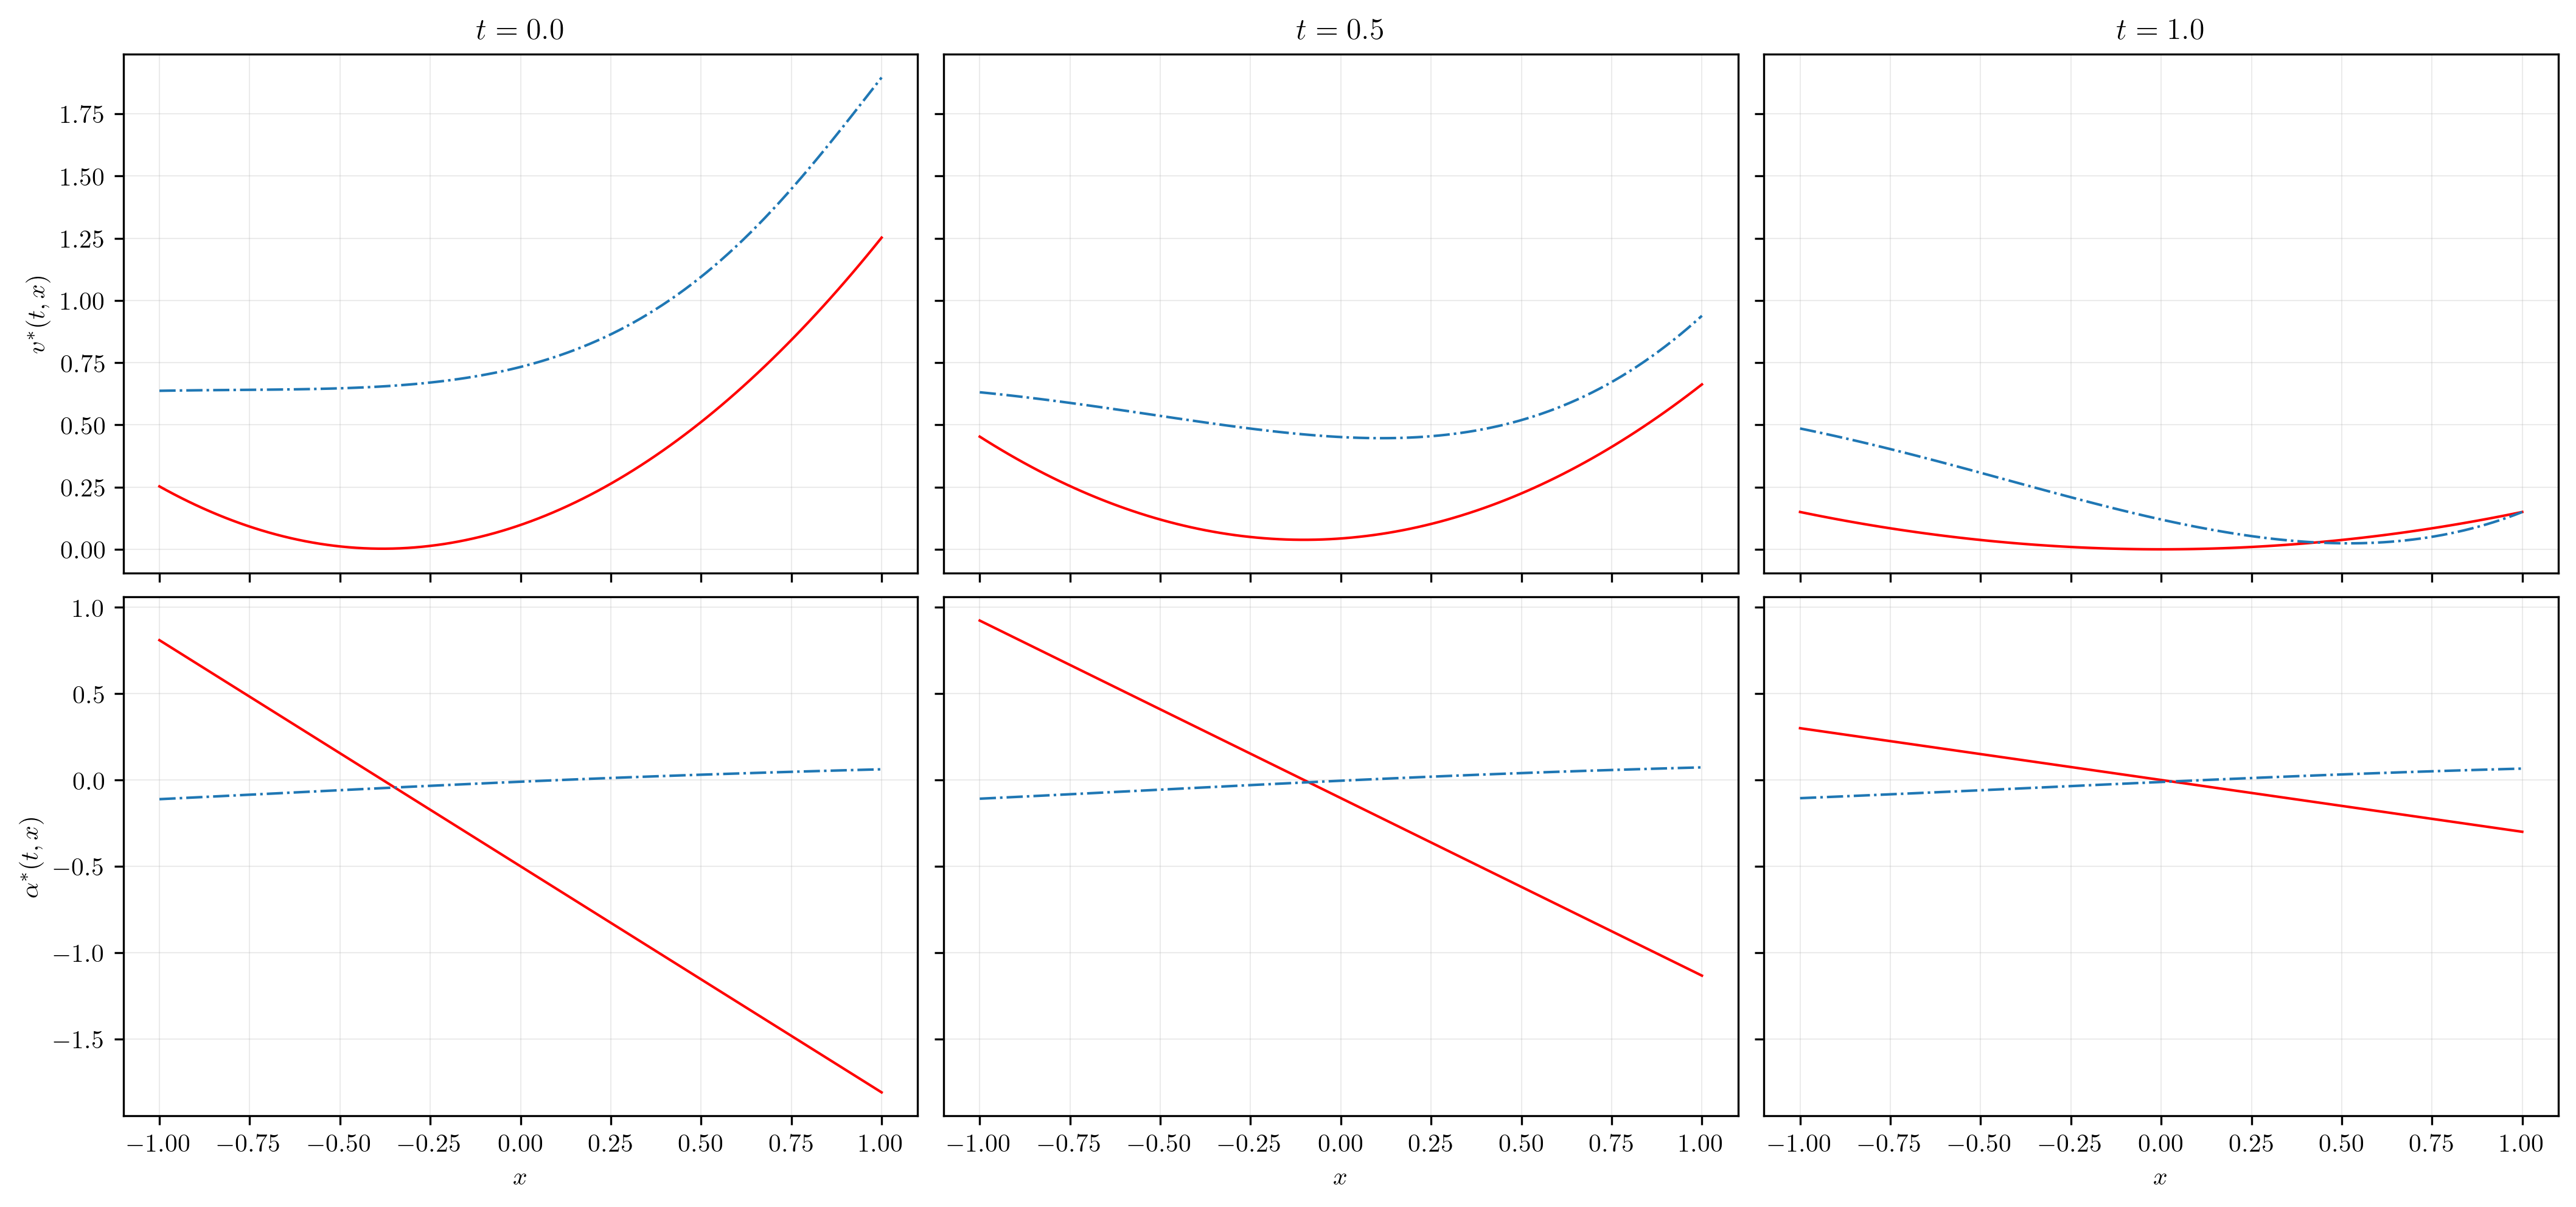

In [5]:
xx = torch.linspace(-1, 1, 100).unsqueeze(-1)

fig, axs = plt.subplots(2, 3, figsize=(14, 6.5), dpi=300, sharex=True, sharey="row", constrained_layout=True)

for t, ax in zip([0.0, 0.5, 1.0], axs.T):
    tt = torch.full_like(xx, fill_value=t)
    with torch.no_grad():
        vv = critic(tt, xx)
        mu, std = actor(tt, xx)
    ax[0].plot(xx, sol.v(t, xx), lw=1, c="red")
    ax[0].plot(xx, vv, lw=1, ls="-.")
    ax[0].grid(lw=0.5, alpha=0.25)
    ax[0].set_title(rf"$t={t}$")
    if t == 0.0:
        ax[0].set_ylabel(r"$v^*(t,x)$")

    ax[1].plot(xx, sol.alpha(t, xx), lw=1, c="red")
    ax[1].plot(xx, mu, lw=1, ls="-.")
    ax[1].grid(lw=0.5, alpha=0.25)
    ax[1].set_xlabel(r"$x$")
    if t == 0.0:
        ax[1].set_ylabel(r"$\alpha^*(t,x)$")

plt.show()